In [1]:
from ProjectRoot import change_wd_to_project_root 
change_wd_to_project_root()

import numpy as np

def create_circle(pts: np.array):
    points = pts[:3]

    A = points[0]
    B = points[1]
    C = points[2]

    a = np.linalg.norm(C - B)
    b = np.linalg.norm(C - A)
    c = np.linalg.norm(B - A)

    s = (a + b + c) / 2

    R = a*b*c / 4 / np.sqrt(s * (s - a) * (s - b) * (s - c))

    b1 = a*a * (b*b + c*c - a*a)
    b2 = b*b * (a*a + c*c - b*b)
    b3 = c*c * (a*a + b*b - c*c)
    P = np.column_stack((A, B, C)).dot(np.hstack((b1, b2, b3)))
    center = P / (b1 + b2 + b3)

    v1 = C - A
    v1 /= np.linalg.norm(v1) 
    v2 = np.cross(C - A, B - A)
    v2 /= np.linalg.norm(v2) 
    
    aap_normal = np.cross(C - A, B - A)
    
    return {"center": center, "radius": R, "v1": v1, "v2": -v2}

def create_circles(dataset, hps_key, ms_key):
    hp_keys = ['RCC', 'LCC', 'ACC']
    ms_keys = ['MS1', 'MS2']
    circles = []
    for i in range(len(dataset)):

        y = dataset[i]
        hps_gt = y[hps_key]
        ms_gt = y[ms_key]
        hp_points_dict = {key: point for key, point in zip(hp_keys, hps_gt)}
        ms_points_dict = {key: point for key, point in zip(ms_keys, ms_gt)}
        points_dict = {**hp_points_dict, **ms_points_dict}
        circle = create_circle(hps_gt)

        circle['points'] = points_dict
        # circle['name'] = dataset.get_subject(i).name
        circles.append(circle)
  
    return circles

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git-repos/floto-federated-knowledge-distillation


In [2]:
from pathlib import Path
import pandas as pd

hps_pred = {'hd': [], 'ms': [], 'hh': []}
ms_pred = {'hd': [], 'ms': [], 'hh': []}
ms_gt = {'hd': [], 'ms': [], 'hh': []}
for ms_path in Path('.').glob('results_*_ms_test.csv'):
    loc = ms_path.name.split('_')[1]
    df = pd.read_csv(ms_path, index_col=0)
    loc_hps_pred = df[[c for c in df.columns if c.startswith('hps_pred')]].to_numpy().reshape(-1,5,3)
    loc_ms_pred = df[[c for c in df.columns if c.startswith('ms_pred')]].to_numpy().reshape(-1,2,3)
    loc_ms_gt = df[[c for c in df.columns if c.startswith('ms_gt')]].to_numpy().reshape(-1,2,3)
    hps_pred[loc].append(loc_hps_pred)
    ms_pred[loc].append(loc_ms_pred)
    ms_gt[loc].append(loc_ms_gt)

In [3]:
hps_pred = {k: np.concatenate(v,axis=0) for k, v in hps_pred.items() if len(v)}
ms_pred = {k: np.concatenate(v,axis=0) for k, v in ms_pred.items() if len(v)}
ms_gt = {k: np.concatenate(v,axis=0) for k, v in ms_gt.items() if len(v)}
{k: v.shape for k, v in hps_pred.items()}, {k: v.shape for k, v in ms_pred.items()}, {k: v.shape for k, v in ms_gt.items()}

({'hd': (16, 5, 3), 'ms': (3, 5, 3), 'hh': (5, 5, 3)},
 {'hd': (16, 2, 3), 'ms': (3, 2, 3), 'hh': (5, 2, 3)},
 {'hd': (16, 2, 3), 'ms': (3, 2, 3), 'hh': (5, 2, 3)})

In [4]:
circle_data_ms_gt, circle_data_ms_pred = {'hd': [], 'ms': [], 'hh': []}, {'hd': [], 'ms': [], 'hh': []}

hps_labels = ['RCC','LCC','ACC','RCA','LCA']
ms_labels = ['MS1','MS2']
for loc in hps_pred:
    loc_hps_pred = hps_pred[loc]
    loc_ms_pred = ms_pred[loc]
    loc_ms_gt = ms_gt[loc]
    for i in range(len(loc_hps_pred)):
        # hps_i = {l: pt for l, pt in zip(hps_labels, loc_hps_pred[i])}
        # ms_pred_i = {l: pt for l, pt in zip(ms_labels, loc_ms_pred[i])}
        # ms_gt_i = {l: pt for l, pt in zip(ms_labels, loc_ms_gt[i])}
        # circle_data_ms_gt[loc].append({**hps_i,**ms_gt_i})
        # circle_data_ms_pred[loc].append({**hps_i,**ms_pred_i})
        if np.any(np.isnan(loc_ms_pred[i])):
            print('HERE')
            continue
        circle_data_ms_gt[loc].append({'hps': loc_hps_pred[i], 'ms':loc_ms_gt[i]})
        circle_data_ms_pred[loc].append({'hps': loc_hps_pred[i], 'ms':loc_ms_pred[i]})

HERE


In [5]:
# dataset = dataset_seg('/mnt/ssd/moritz/data/HPs and CAs in TAVI CTs')
# dataset.keys = ["hps_gt.mps",
#                 "ms_gt.mps",
#                 "pts_pred.mps",
#                 "ms_pred.mps",
#                 "HP/"]
# circles = create_circles(dataset, "HP/", "ms_pred.mps")

# dataset = dataset_seg('/mnt/ssd/moritz/data/CTs and MSs')
# dataset.keys = ["MS/",
#                 "t_points_fullres.mps",
#                 'mean_pts_ms.mps']
# pred_circles = create_circles(dataset, "t_points_fullres.mps", "mean_pts_ms.mps")
# gt_circles = create_circles(dataset, "t_points_fullres.mps", "MS/")
circles_ms_gt = {loc: create_circles(data, 'hps', 'ms') for loc, data in circle_data_ms_gt.items()}
circles_ms_pred = {loc: create_circles(data, 'hps', 'ms') for loc, data in circle_data_ms_pred.items()}

In [13]:
import matplotlib.patches as patches
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

cp = sns.color_palette()
LEGEND = {
    'hd': {'color': cp[0], 'name': 'Heidelberg'},
    'ms': {'color': cp[2], 'name': 'Muenster'},
    'hh': {'color': cp[6], 'name': 'Hamburg'}
}

def angle_between_vectors(v1, v2):
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    return np.degrees(np.arccos(np.clip(cos_theta, -1.0, 1.0)))

def plot_ms_points(loc_circles):
    fig, axs = plt.subplots(figsize=(7.5, 7.5))
    # sns.set_style("whitegrid")
    
    loc_angles = {loc: [] for loc in loc_circles} # []
    max_radius = 0
    for loc, circles in loc_circles.items():
        for circle in circles:
            normal = -circle["v2"]
            pts = circle["points"]
            ms1 = pts["MS1"]
            ms2 = pts["MS2"] 
            vector_ms1_ms2 = ms2 - ms1
            angle = angle_between_vectors(normal, vector_ms1_ms2)
            if np.isnan(angle):
                print('')
            loc_angles[loc].append(angle)
            if circle["radius"] > max_radius:
                max_radius = circle["radius"]
    
    cmap_angle = plt.cm.get_cmap("Greys") # cm.viridis
    all_angles = np.concatenate(list(loc_angles.values()), axis=0)
    norm_angle = Normalize(vmin=np.min(all_angles), vmax=np.max(all_angles))    
        

    # AAPlane-Line
    line_x = [-max_radius/2, max_radius/2]
    line_y = [0, 0]
    axs.plot(line_x, line_y, color='gray', linestyle='--', linewidth=1, label='AA Plane', alpha=1)
    
        
    max_val = 0
    for j, (loc, circles) in enumerate(loc_circles.items()):
        angles = loc_angles[loc]
        for i, (circle, angle) in enumerate(zip(circles,angles)):

            pts = circle["points"]
            acc_rcc_midpoint = (np.array(pts['ACC']) + np.array(pts['RCC'])) / 2
            v1 = circle["v1"]
            v2 = circle["v2"]
            # color_angle = cmap_angle(norm_angle(angle))
            color_angle = LEGEND[loc]['color']
            alpha = np.clip(angle / np.max(all_angles), 0.3, 1)
            # Project points
            ms1 = np.dot(pts["MS1"] - acc_rcc_midpoint, v1), np.dot(pts["MS1"] - acc_rcc_midpoint, v2)
            ms2 = np.dot(pts["MS2"] - acc_rcc_midpoint, v1), np.dot(pts["MS2"] - acc_rcc_midpoint, v2)
            
            # if ms1[0] < -20:
            #     print(circle["name"])
            # print(ms1)
            acc = np.dot(pts["ACC"] - acc_rcc_midpoint, v1), np.dot(pts["ACC"] - acc_rcc_midpoint, v2)
            rcc = np.dot(pts["RCC"] - acc_rcc_midpoint, v1), np.dot(pts["RCC"] - acc_rcc_midpoint, v2)
            axs.scatter(acc[0], acc[1], color='gray', alpha=0.2, marker='^')
            axs.scatter(rcc[0], rcc[1], color='gray', alpha=0.2, marker='s')
            if j == 0 and i == 0:
            
                axs.annotate('NCC', xy=(acc[0], acc[1]), xytext=(acc[0] + 5, acc[1] + 5),
                        arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='->'),
                        fontsize=12)
                axs.annotate('RCC', xy=(rcc[0], rcc[1]), xytext=(rcc[0] + 5, rcc[1] + 5),
                        arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='->'),
                        fontsize=12)
            
            # Max value for colorbar
            max_val = max(max_val, np.abs(np.array([ms1, ms2])).max())
            
            dx = ms2[0] - ms1[0]
            dy = ms2[1] - ms1[1]

            axs.quiver(
                ms2[0], ms2[1], -dx, -dy, 
                angles="xy", 
                scale_units="xy", 
                scale=1, 
                color=color_angle,
                # alpha=alpha, 
                width=0.003,   
                headwidth=3.,     
                headlength=2.,  
                linewidth=0.5,
                label="Membranous Septum"  
            )

            axs.scatter(ms2[0], ms2[1], color=color_angle, label="Lower MS Point")#, alpha=alpha)
           
    # cax = fig.add_axes([1.02, 0.17, 0.04, 0.6])
    # cb = plt.colorbar(cm.ScalarMappable(norm=norm_angle, cmap=cmap_angle), cax=cax)
    # cb.set_label('Angle between AA-Plane Normal and MS1-MS2 Vector')
    
    axs.set_xlabel("mm")
    axs.set_ylabel("mm")
    plt.tight_layout()
    
    axs.set_aspect('equal')
    
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='MS2'),
        Line2D([0], [0], color='gray', lw=1, label='MS2 to MS1'),
        Line2D([0], [0], color='gray', linestyle='--', linewidth=1, label='AA Plane'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=cp[0], markersize=10, label='L1'), #'Heidelberg'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=cp[2], markersize=10, label='L3'), # 'Muenster'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=cp[6], markersize=10, label='L7'), # 'Hamburg'),
    ]
    axs.legend(handles=legend_elements, loc='upper left')
    
    max_val *= 1.1
    axs.set_xlim([-max_val, max_val])
    axs.set_ylim([-max_val, 10])

    return fig

# plot_ms_points(circles_ms_gt) #['hh'])


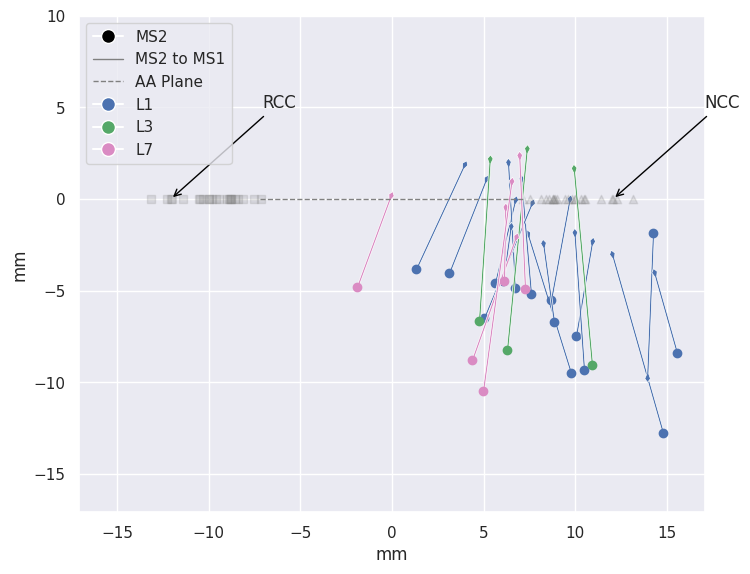

In [14]:
fig = plot_ms_points(circles_ms_gt)
fig.tight_layout()
fig.savefig('./notebooks/images2/ms_gt.pdf', bbox_inches='tight')

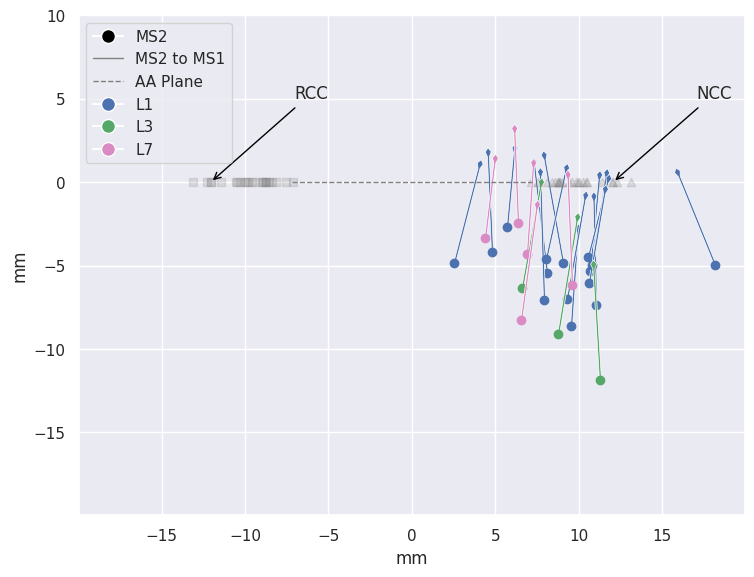

In [15]:
fig = plot_ms_points(circles_ms_pred)
fig.tight_layout()
fig.savefig('./notebooks/images2/ms_pred.pdf', bbox_inches='tight')